# Tutorial 5: Mouse Thymus Dataset

In this tutorial, we valuate SpaKnit's capabilities on integrating multiple omics modalities while ensuring seamless compatibility with downstream tasks. We apply SpaKnit to mouse thymus dataset to demonstrate its capability for robust and batch-consistent integration across modalities. The thymus, a small gland divided into two left- and right-hand lobes connected by a fibrous isthmus, contains a central medulla and a peripheral cortex.

All datasets used in this paper are available at https://doi.org/10.5281/zenodo.14854747.

## Loading package

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

import os
os.environ['R_HOME'] = 'E:/R-4.3.1'
os.environ['R_USER'] = 'E:/anaconda/lib/site-packages/rpy2'

import sys
sys.path.append(r'..')
from Model.INR import INRModel
from Model.utils import mclust_R, reorder_categories
from Model.model import DCCAE
from Model.preprocess import fix_seed, preprocessing
fix_seed(2024)

## Loading and preprocessing data

In [6]:
adata_modality_1 = sc.read_h5ad("../Data/Mouse_Thymus_1/adata_RNA.h5ad")
adata_modality_2 = sc.read_h5ad("../Data/Mouse_Thymus_1/adata_ADT.h5ad")

adata_modality_1.var_names_make_unique()
adata_modality_2.var_names_make_unique()

fix_seed(2024)
adata_modality_1, adata_modality_2 = preprocessing(adata_modality_1, adata_modality_2, 'Stereo-CITE-seq')
adata_modality_1.X = adata_modality_1.uns['INR']
adata_modality_2.obsm['X_pca'] = adata_modality_2.uns['INR']
sc.pp.pca(adata_modality_1)

Stereo-CITE-seq data preprocessing have done!
Dimensions after preprocessed adata_modal_1: (4183, 3000)
Dimensions after preprocessing adata_modal_2: (4183, 19)


## Training the model

### INR module

All parameters of the INR model remain the same across the three slices.

| replicate | epoch of modality 1 | epoch of modality 2 |
|:------:|:------:|:------:|
| 1 |  1500  |  500  |
| 2 |  1500 |  500  |
| 3 |  1500 |  500  |

In [ ]:
## INR module training
def Spatially_Continuous_Reconstruction(adata, epoch_num):
    coords = adata.obsm['spatial'].astype(np.float32)
    node_feats = adata.X.astype(np.float32)

    coords = torch.from_numpy(coords).float()
    if isinstance(node_feats, csr_matrix):
        node_feats = node_feats.toarray()
    node_feats = torch.from_numpy(node_feats).float()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    node_feats = node_feats.to(device)
    coords = coords.to(device)
    
    print(f'out_dim: {node_feats.shape[1]}')

    model = INRModel(
        X=node_feats,
        spatial_coord=coords,
        device=device,
        learning_rate=1e-4,
        reg_par=0,
        epoch_num=epoch_num,
        print_train_log_info=True
    )

    reconstructed_X = model.fit()
    if 'INR' not in adata.uns:
        adata.uns['INR'] = reconstructed_X

# modality 1
Spatially_Continuous_Reconstruction(adata_modality_1, 1500)

# modality 2
Spatially_Continuous_Reconstruction(adata_modality_2, 500)

### DCCAE module

In [ ]:
n_output = 19
features1 = adata_modality_1.obsm['X_pca'].shape[1]  # Feature sizes
features2 = adata_modality_2.obsm['X_pca'].shape[1]
layers1 = [256, 256, n_output]  # nodes in each hidden layer and the output size
layers2 = [256, 256, n_output]

X = adata_modality_1.obsm['X_pca'].copy()
Y = adata_modality_2.obsm['X_pca'].copy()

use_rep = ['DCCAE_X', "DCCAE_Y", "DCCAE"]
n_DCCAE = 8
epochs = 150
model = DCCAE(input_size1=features1, input_size2=features2, n_components=n_DCCAE, layer_sizes1=layers1, layer_sizes2=layers2, epoch_num=epochs)
model.fit([X, Y])
Xs_transformed = model.transform([X, Y])
adata_modality_1.obsm["DCCAE_X"] =  Xs_transformed[0]
adata_modality_2.obsm["DCCAE_Y"] =  Xs_transformed[1]
adata_modality_1.obsm["DCCAE"] = np.concatenate((adata_modality_1.obsm["DCCAE_X"], adata_modality_2.obsm["DCCAE_Y"]),axis=1)

Training Progress: 100%|██████████| 150/150 [00:30<00:00,  4.90it/s]

model training finished!


In [235]:
use_rep = ['DCCAE_X', 'DCCAE_Y', 'DCCAE']
mclust_R(adata_modality_1, used_obsm=use_rep[2], num_cluster=7)

fitting ...
  |======================================================================| 100%


AnnData object with n_obs × n_vars = 4183 × 3000
    obs: 'orig.ident', 'x', 'y', 'n_genes', 'clusters_mclust'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'INR', 'hvg', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca', 'DCCAE_X', 'DCCAE'
    varm: 'PCs'

In [ ]:
# Slices need to be rotated 90 degrees clockwise
coordinates = adata_modality_1.obsm['spatial']

rotated_coordinates = np.zeros_like(coordinates)  
rotated_coordinates[:, 0] = -coordinates[:, 1]
rotated_coordinates[:, 1] = coordinates[:, 0]

adata_modality_1.obsm['spatial'] = rotated_coordinates

## Visualizing and Analysing

In [4]:
def replace_extreme_values(arr, n=0.005):
    """
    Replaces extreme values in the expression data to optimize visualization effects.

    Parameters
    ----------
    arr : ndarray
        The input array.

    n : float, optional (default=0.005)
        The percentage of extreme values to be replaced.

    Returns
    -------
    arr_copy : ndarray
        The array with extreme values replaced.
    """
    # Replace the extreme values that are 2*n in number
    # Calculate the number to replace
    num_to_replace = int(len(arr) * n)
    # Sort the array
    sorted_arr = np.sort(arr)
    # Find the value at the n% percentile
    value_n_percentile = sorted_arr[num_to_replace - 1]  # The index for the n% percentile is num_to_replace - 1
    # Find the value at the (100-n)% percentile
    value_100_n_percentile = sorted_arr[-(num_to_replace + 1)]

    # Find the indices for the bottom n% and top n% values
    min_indices = np.argpartition(arr, num_to_replace)[:num_to_replace]
    max_indices = np.argpartition(arr, -num_to_replace)[-num_to_replace:]

    # Create a copy of the original array
    arr_copy = arr.copy()
    # Replace the extreme values
    arr_copy[min_indices] = value_n_percentile
    arr_copy[max_indices] = value_100_n_percentile

    return arr_copy

### "Background noise" versus extracted feature
RNA modality often exhibits “background noise” due to uneven cell density, which can obscure accurate feature extraction. Using SpaKnit, we extracted features that overcame these defects, revealing clear spatial domains corresponding to the cortex, medulla, and connective tissue

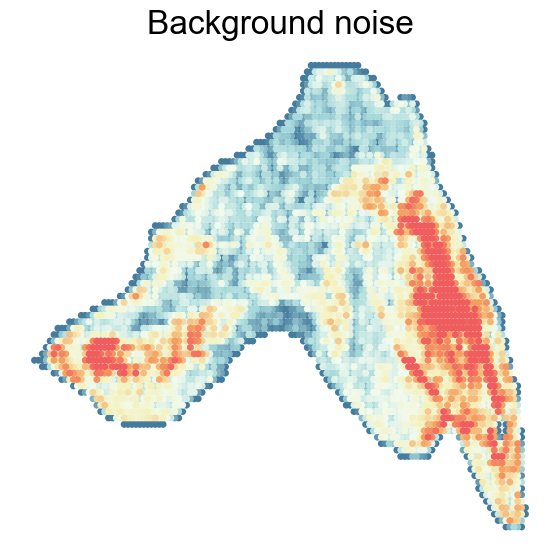

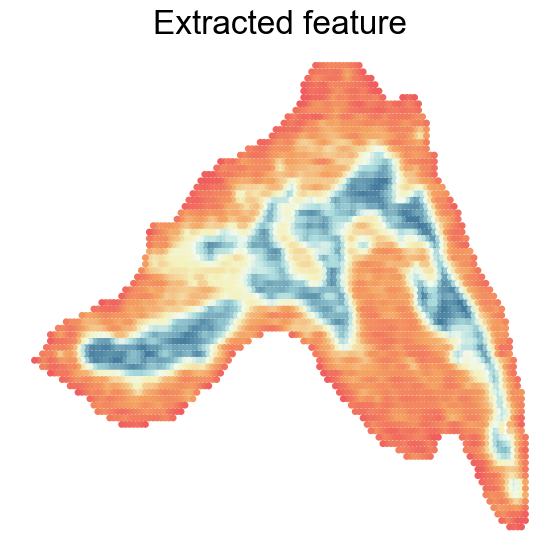

In [6]:
## Visualization of "Background noise"
adata_modality_1 = sc.read_h5ad("../Data/Mouse_Thymus_1/adata_RNA.h5ad")
adata_modality_1.obs['background'] = np.sum(adata_modality_1.X.toarray(), axis=1).ravel()
adata_modality_1.obs['background'] = replace_extreme_values(adata_modality_1.obs['background'], n=0.05)
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = 'Arial'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
colors = ["#457b9d","#a8dadc", "#f1faee", "#f4f1bb", "#f4a261", "#f05d5e"]
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)
sc.pl.embedding(adata_modality_1, basis="spatial", color='background', ax=ax, show=False, cmap=cmap, colorbar_loc=None, s=100)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Background noise')
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()


## ## Visualization of extracted feature
adata_analysis = sc.read_h5ad("../Results/Mouse_Thymus_Replicate1.h5ad")
componts_num = 0
adata_analysis.obs[f'feat_{componts_num}'] = adata_analysis.obsm["SpaKnit"][:, 0]
adata_analysis.obs[f'feat_{componts_num}'] = replace_extreme_values(adata_analysis.obs[f'feat_{componts_num}'], n=0.005)

plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = 'Arial'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
colors = ["#457b9d","#a8dadc", "#f1faee", "#f4f1bb", "#f4a261", "#f05d5e"]
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)
sc.pl.embedding(adata_analysis, basis="spatial", color=f'feat_{componts_num}', ax=ax, show=False, cmap=cmap, colorbar_loc=None, s=100)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title(f'Extracted feature')
ax.invert_yaxis()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

### Spatial Domain Identification

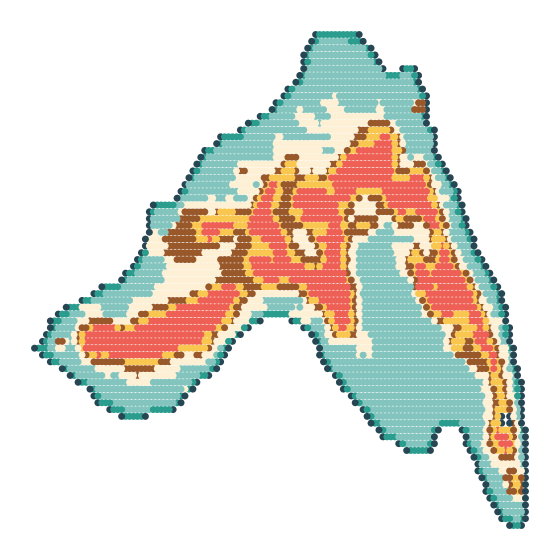

In [7]:
import warnings
warnings.filterwarnings('ignore')
import scanpy as sc
import matplotlib.pyplot as plt


## visualization of SpaKnit
method = 'SpaKnit'

colors = [
    '#264653', '#83c5be', '#2a9d8f', '#f9c74f', '#99582a', '#ee6055', '#fdf0d5'
]

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sc.pl.embedding(adata_analysis, basis='spatial', color=[method], ax=ax, s=100, show=False, palette=colors)
ax.set_title(f'')
ax.set_xlabel('')
ax.set_ylabel('')
ax.invert_yaxis()
# remove legend
ax.get_legend().remove()
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()

### PAGA Graph
After identifing spatial domains acorss three slices, we performed trajectory inference using the Partition-based graph abstraction (PAGA) method to assess relationships among cell types and states.

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
sc.pp.neighbors(adata_analysis, use_rep=method)
sc.tl.paga(adata_analysis, groups=method)
sc.pl.paga(adata_analysis, edge_width_scale=2, node_size_scale=8, ax=ax, fontsize=24, fontoutline=4, show=False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

## Identifying the marker genes

In [237]:
## obs store the clustering results
## uns store the integrated embeddings
# adata_SpaKnit = anndata.AnnData()
adata_SpaKnit = anndata.AnnData()
adata_SpaKnit.obs['SpaKnit'] = adata_modality_1.obs['clusters_mclust']
adata_SpaKnit.obsm['SpaKnit'] = adata_modality_1.obsm['DCCAE']
adata_SpaKnit.obsm['spatial'] = adata_modality_1.obsm['spatial']
adata_SpaKnit.write_h5ad('D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Mouse_Thymus_Replicate1.h5ad')

In [230]:
adata_SpaKnit

AnnData object with n_obs × n_vars = 4573 × 0
    obs: 'SpaKnit'
    obsm: 'SpaKnit', 'spatial'

In [238]:
## calculate the marker genes
sc.tl.dendrogram(adata_modality_1, groupby='clusters_mclust')
sc.tl.rank_genes_groups(adata_modality_1, groupby='clusters_mclust', use_raw=False)

rank_genes = sc.get.rank_genes_groups_df(adata_modality_1, group=None)
rank_genes.to_excel("D:/study/learning/spatial_transcriptome/papers/spatial_multi_omics-main/Results/Visualization/Mouse_Thymus/Replicate1/" + 'Replicate1_marker_genes.xlsx', index=True)